# Exploratory Data Analysis of Multiome Data (ATAC/RNA)

In [1]:
import sys
sys.path.insert(1, "/Users/smgroves/Dropbox (VU Basic Sciences)/pycharm_workspace/mazebox/")
import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing

In [2]:
data = pd.read_csv('../data/data_from_debbie/scaled-SCT-data_small.csv', header = 0, index_col = 0)
data.head()

,AAACAGCCAAAGCGGC-1,AAACAGCCAAGTAAGC-1,AAACAGCCATAGACCC-1,AAACATGCAACTGGCT-1,AAACATGCAATGAAGC-1,AAACATGCATTAAGTC-1,AAACATGCATTGGGAG-1,AAACCAACAGCTTACA-1,AAACCAACAGGACCTT-1,AAACCAACATTAGCGC-1,...,TTTGTGGCAGAAACGT-1,TTTGTGGCAGACAAAC-1,TTTGTGGCAGGCAAGC-1,TTTGTGGCAGGCATCT-1,TTTGTGTTCCCGTTGT-1,TTTGTGTTCCTTGCAC-1,TTTGTTGGTATTTGCC-1,TTTGTTGGTGTGAGGA-1,TTTGTTGGTTAGTTGG-1,TTTGTTGGTTATCCGT-1
Xkr4,-0.336302,-0.336302,-0.336302,-0.336302,-0.336302,-0.336302,-0.336302,-0.336302,-0.336302,-0.336302,...,-0.336302,-0.336302,-0.336302,-0.336302,-0.336302,2.479731,-0.336302,2.479731,-0.336302,-0.336302
Alkal1,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390,...,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390,-0.168390
Rrs1,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946,...,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946,-0.113946
Cpa6,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749,...,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749,-0.063749
Prex2,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797,...,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797,-0.072797


# Signature Subtyping

In [3]:
sig_matrix = pd.read_csv('/Users/smgroves/Dropbox (VU Basic Sciences)/pycharm_workspace/mazebox/mazebox/examples/data/sig_matrix_ParTI.csv', header =0, index_col = 0)
sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)
ind = []
for i in sig_matrix.index:
    ind.append(i.capitalize())
sig_matrix.index = ind


In [4]:

def transform_tumor_space(data, gene_sig, unlog = False, type = None, scale = False, scaling = None, spliced = False, eps = 0.001):
    tumor = data.copy()
    if unlog == True:
        tumor = np.expm1(tumor)
    print("Transforming tumor data...")
    glist_keep = []
    for num,i in enumerate(gene_sig.index.values):
        if i in tumor.index:
            glist_keep.append(i)
        # if num % 1000 == 0:
        #     print(num)
    gene_sig = gene_sig.loc[gene_sig.index.isin(glist_keep)]
    if np.all(np.linalg.norm(gene_sig, axis = 0) != 1-eps):

        gene_sig = gene_sig / np.linalg.norm(gene_sig, axis=0)
    print("Gene signature matrix now has shape: ", gene_sig.shape)
    tumor = tumor.loc[gene_sig.index.values]
    print("Tumor data shortened to genes in gene list...")
    
    lanorm =np.linalg.norm(tumor, axis = 1)
    df = (tumor.T/np.linalg.norm(tumor, axis = 1)).T
    print("Tumor data subsetting complete.")
    print(gene_sig.shape, df.shape)
    df_inv, resid, rank, sing_values = np.linalg.lstsq(gene_sig, np.array(df))
    out = pd.DataFrame(df_inv.T)
    # out = np.arcsinh((out))
    if scale == True:
        out = out / scaling
    return out, gene_sig, tumor, lanorm

            



In [5]:

sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)
out, sig_matrix1, tumor, lanorm = transform_tumor_space(data, sig_matrix, unlog=False, scale=False,
                                                                     type=type)


Transforming tumor data...
Gene signature matrix now has shape:  (30, 5)
Tumor data shortened to genes in gene list...
Tumor data subsetting complete.
(30, 5) (30, 8391)


In [6]:
out.index = data.columns
out.columns = sig_matrix.columns
out.head()

,SCLC-A,SCLC-A2,SCLC-N,SCLC-P,SCLC-Y
AAACAGCCAAAGCGGC-1,0.003348,-0.009018,-0.003581,0.001577,-0.004884
AAACAGCCAAGTAAGC-1,-0.006268,-0.006149,0.008401,0.004900,-0.010098
AAACAGCCATAGACCC-1,0.024845,-0.024075,0.027183,0.010345,-0.027758
AAACATGCAACTGGCT-1,0.012216,-0.019532,0.004980,0.010806,-0.013673
AAACATGCAATGAAGC-1,0.003348,-0.009018,-0.003581,0.001577,-0.004884


In [7]:
sig_matrix1.style.background_gradient('viridis')

,SCLC-A,SCLC-A2,SCLC-N,SCLC-P,SCLC-Y
Elavl3,0.359595,0.167409,0.389783,0.009543,0.019757
Pcp4,0.356760,0.223638,0.203918,0.102905,0.029774
Sox1,0.314938,0.118820,0.079528,0.064140,-0.019592
Ptn,0.265750,0.100070,0.151538,-0.045614,0.121141
Nnat,0.186512,0.060123,0.152756,0.084468,0.041447
Fli1,0.150700,0.113211,0.018656,0.086644,-0.012750
Ascl1,0.392177,0.428707,0.116652,0.056479,0.034616
Elf3,0.192364,0.347783,-0.007816,0.257479,0.064341
Wfdc2,0.303412,0.302425,0.097909,0.182100,0.102941
Fam3b,0.129898,0.284329,-0.031590,0.122333,0.006194


## Labeling subtypes
Read in labels so I can compare subtyping to labeled clusters

In [8]:
idents = pd.read_csv('../data/sclc_idents.csv', header = 0, index_col = 0)
idents.head()

,V1
AAACAGCCAAAGCGGC-1,NE_2
AAACAGCCAAGTAAGC-1,NE_3
AAACAGCCATAGACCC-1,NFIB high_NE
AAACATGCAACTGGCT-1,NE_6
AAACATGCAATGAAGC-1,NE_2


In [9]:
out['idents'] = idents

In [10]:
out.groupby('idents').mean().sort_values('SCLC-A2').index

Index(['Endothelial cells', 'Club cells_3', 'NFIB high_NE', 'Club cells_1',
       'AT2 cells', 'Club cell_2', 'Stromal cells', 'NE_4', 'NE_6', 'NE_3',
       'NE_1', 'NE_8', 'NE_7', 'NE_2', 'NE_5'],
      dtype='object', name='idents')

In [11]:
out.columns[0:5]

Index(['SCLC-A', 'SCLC-A2', 'SCLC-N', 'SCLC-P', 'SCLC-Y'], dtype='object')

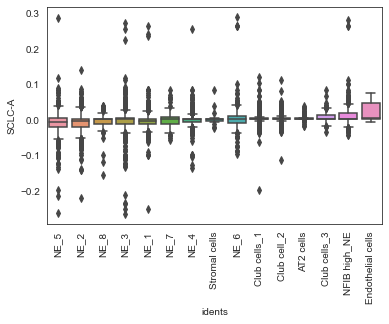

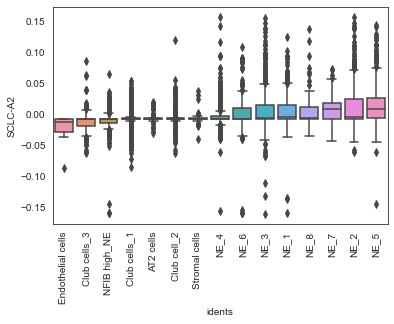

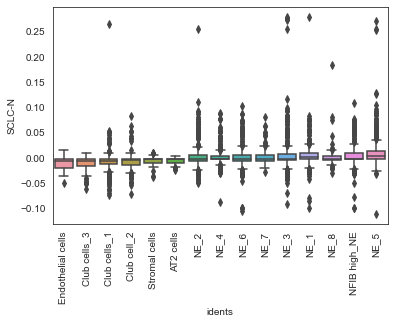

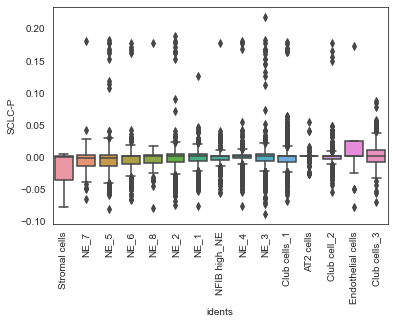

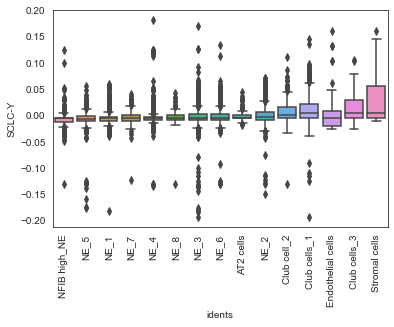

In [12]:
for i in out.columns[0:5]:
    sns.boxplot(data = out, x = 'idents', y= i, order = out.groupby('idents').mean().sort_values(i).index)
    plt.xticks(rotation = 90)
    plt.show()

## PCA from embedding (done in R)

In [13]:
pca = pd.read_csv("../data/data_from_debbie/pca-embedding_small.csv", index_col=0)
pca

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50
AAACAGCCAAAGCGGC-1,-2.842498,-1.840267,0.785761,-3.980610,-0.063160,3.071289,-0.577154,-2.869823,2.683700,0.309823,...,-1.855401,2.129822,1.851389,0.963781,0.609554,-0.059130,0.951301,-0.354904,0.817346,-0.544517
AAACAGCCAAGTAAGC-1,-2.236536,-0.654765,2.790614,-3.602785,-1.651946,-0.007621,0.407949,-0.012575,1.632204,0.332537,...,1.478523,0.502836,2.531467,-0.755048,1.528345,-0.037308,0.247087,-0.455941,-2.033513,-0.475184
AAACAGCCATAGACCC-1,-3.706710,-1.246320,-0.848212,0.072081,-0.852616,0.778574,-0.417902,0.858350,-2.392902,1.748746,...,2.748061,1.048731,0.294562,1.156733,-1.193917,0.679340,-0.308640,0.949900,1.141768,0.208834
AAACATGCAACTGGCT-1,-2.487192,-0.780550,0.574893,6.641088,0.742283,3.192447,-0.023154,0.485362,1.655358,3.557191,...,-0.999407,-1.284592,2.359663,1.042089,1.086634,-0.867056,-1.136592,-0.265364,-0.553145,-1.571016
AAACATGCAATGAAGC-1,-7.485961,5.896837,-0.541735,-6.197725,2.280778,4.751325,-0.425234,-5.337725,4.806929,0.988878,...,-1.736307,6.587950,4.723972,1.198279,-0.035142,-0.555610,0.208701,-0.852847,1.338519,-0.785639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCCTTGCAC-1,-4.275040,-3.835039,-2.434209,-0.718045,-0.878691,-2.192656,-0.047848,0.513119,1.504082,-0.015445,...,0.226974,-0.045357,-1.021489,0.393206,0.180613,-1.026121,0.941622,-0.991191,1.446121,0.573465
TTTGTTGGTATTTGCC-1,0.469239,-3.481612,3.524412,0.158209,-0.779195,-0.492389,0.878620,-1.105115,0.128212,-1.371052,...,0.343892,0.106290,0.168364,-0.377885,-0.579125,-0.605220,1.197660,-0.119965,0.455339,-0.355718
TTTGTTGGTGTGAGGA-1,-2.199945,-3.571710,1.973680,-2.466523,-0.990974,0.624756,0.310676,0.819366,-1.626575,-1.110913,...,0.012801,-0.496540,-1.294223,-0.125709,-1.415737,0.091624,-0.986990,-0.069299,-1.108414,0.583609
TTTGTTGGTTAGTTGG-1,-2.586964,-2.787094,0.478532,-1.286008,-0.037879,-0.058354,-0.788300,0.596262,0.789573,-1.060778,...,0.538702,-0.257285,0.174417,-0.951558,-0.629522,-0.611388,-0.274789,-0.085765,-0.624671,0.018604


<AxesSubplot:xlabel='PC_2', ylabel='PC_3'>

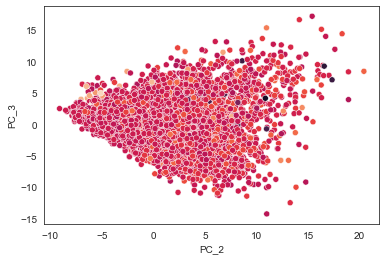

In [16]:
sns.scatterplot(pca.PC_2, pca.PC_3, c = out['SCLC-Y'])


## UMAP plots

In [17]:
umap = pd.read_csv("../data/data_from_debbie/umap-embedding_small.csv", index_col=0)


In [18]:
umap.UMAP_1.reindex(list((out.idents).sort_values().index.tolist()))


GATCGCTCAGGATAAC-1    -7.874221
ACTCAGTAGTGTTGTA-1    -8.478532
GATGGCTGTATCTGGA-1    -8.252414
GTAGTTTCATTCAGCA-1    -8.163833
ATTGGTTCAAAGCCTC-1    -8.409087
                        ...    
ATGAAGCCAAGCGAGC-1    11.610442
ATTAGCTCAATAGCCC-1    11.666895
GAAGGAACACATTGCA-1    11.184396
CCGATGCAGGAAGCTA-1    11.790757
TTGGCTTGTAAGGTTT-1    11.151863
Name: UMAP_1, Length: 8391, dtype: float64

<AxesSubplot:xlabel='UMAP_1', ylabel='UMAP_2'>

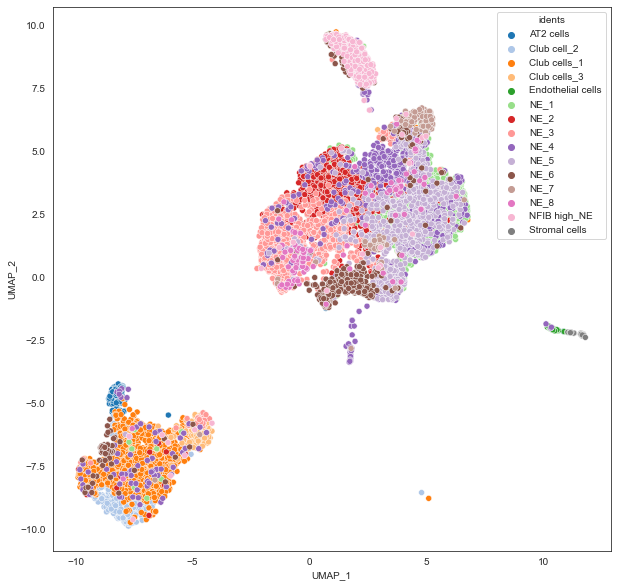

In [19]:
plt.figure (figsize = (10,10))
sorted_ind = (out.idents).sort_values().index
sns.scatterplot(umap.UMAP_1.reindex(sorted_ind), umap.UMAP_2.reindex(sorted_ind), hue = out['idents'].sort_values(), palette='tab20')


<AxesSubplot:xlabel='UMAP_1', ylabel='UMAP_2'>

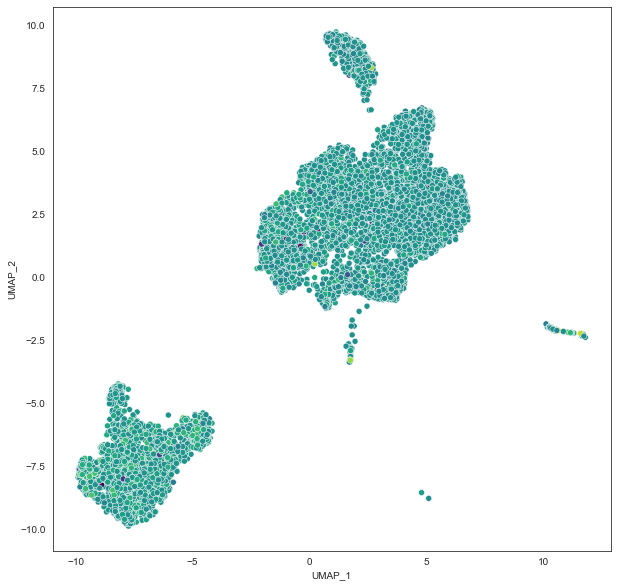

In [20]:
plt.figure (figsize = (10,10))

sns.scatterplot(umap.UMAP_1, umap.UMAP_2, c = out['SCLC-Y'], cmap = 'viridis')

<AxesSubplot:xlabel='UMAP_1', ylabel='UMAP_2'>

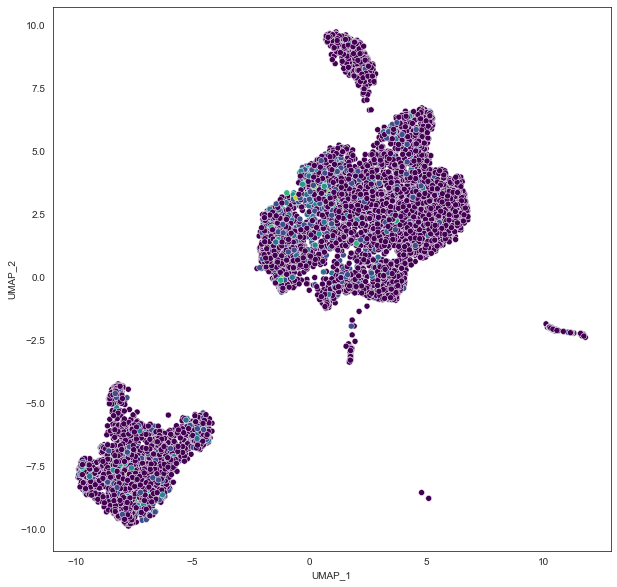

In [21]:
plt.figure (figsize = (10,10))

sns.scatterplot(umap.UMAP_1, umap.UMAP_2, c = data.T.Anxa1, cmap = 'viridis')

# Signature Subtyping with MAGIC Imputed Data

In [23]:
imputed_data = pd.read_csv('../data/TKO_imputed.csv.gz')

In [32]:
imputed_data.index = imputed_data['Unnamed: 0']
imputed_data = imputed_data.drop('Unnamed: 0', axis = 1)
imputed_data.tail()

,Xkr4,Gm19938,Rp1,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,X4732440D04Rik,...,mt.Nd6,mt.Cytb,AC133103.1,AC168977.1,CAAA01118383.1,Csprs,Vamp7,Tmlhe,CAAA01147332.1,AC149090.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TTTGTGTTCCTTGCAC-1,0.124733,0.001216,0.000382,0.007876,0.018022,0.057922,0.045896,0.009496,0.079067,0.003846,...,0.411910,6.666118,0.000284,0.000881,0.001451,0.000214,0.000287,0.008759,0.003254,0.372038
TTTGTTGGTATTTGCC-1,0.072145,0.000467,0.016080,0.009277,0.023373,0.066785,0.036066,0.013011,0.106167,0.006022,...,0.401365,5.600654,0.001948,0.000758,0.003533,0.002863,0.001675,0.014741,0.002888,0.418010
TTTGTTGGTGTGAGGA-1,0.084807,0.000387,0.000288,0.003846,0.009462,0.043931,0.035255,0.004601,0.056832,0.001886,...,0.441194,7.267999,0.000210,0.000412,0.000547,0.000220,0.000394,0.006325,0.002698,0.304628
TTTGTTGGTTAGTTGG-1,0.126590,0.001109,0.000737,0.007836,0.018978,0.059415,0.046948,0.010347,0.082905,0.004124,...,0.417724,6.529814,0.000345,0.000788,0.001761,0.000299,0.000361,0.009061,0.003259,0.374643
TTTGTTGGTTATCCGT-1,0.137269,0.000934,0.002659,0.008846,0.023225,0.066993,0.051703,0.013797,0.107802,0.005249,...,0.407622,5.729509,0.000607,0.000417,0.003305,0.001017,0.000857,0.009843,0.003397,0.399713


In [35]:
imputed_data = imputed_data.loc[data.columns]

<AxesSubplot:xlabel='UMAP_1', ylabel='UMAP_2'>

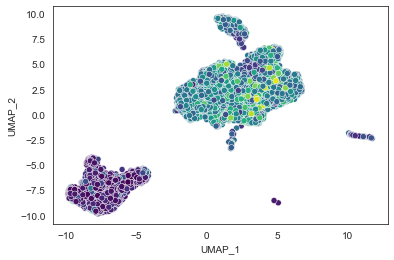

In [36]:
sns.scatterplot(umap.UMAP_1, umap.UMAP_2, c = imputed_data.Ascl1, cmap = 'viridis')

In [43]:

sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)
out, sig_matrix1, tumor, lanorm = transform_tumor_space(imputed_data.T, sig_matrix, unlog=False, scale=False,
                                                                     type=type)


Transforming tumor data...
Gene signature matrix now has shape:  (72, 5)
Tumor data shortened to genes in gene list...
Tumor data subsetting complete.
(72, 5) (72, 8391)


In [44]:
out

,0,1,2,3,4
0,-0.004491,0.032387,0.023724,0.004485,0.002069
1,-0.002671,0.033543,0.022420,0.007347,0.005207
2,-0.011556,0.057253,0.059965,0.023960,-0.015061
3,0.008083,0.026434,0.032994,0.000234,0.003392
4,-0.021447,0.061931,0.061546,0.032809,-0.022557
...,...,...,...,...,...
8386,0.000757,0.025980,0.018895,0.000536,0.003852
8387,-0.002149,0.025869,0.022373,0.003210,0.024232
8388,0.003021,0.015716,0.015600,0.002072,0.007901
8389,0.000593,0.026698,0.019201,0.001750,0.003801


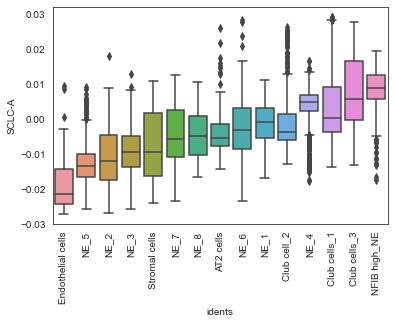

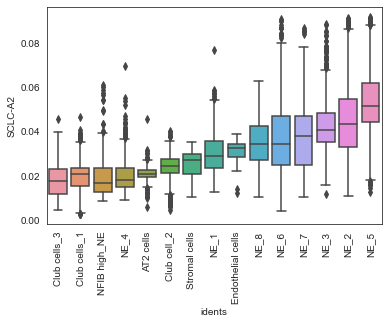

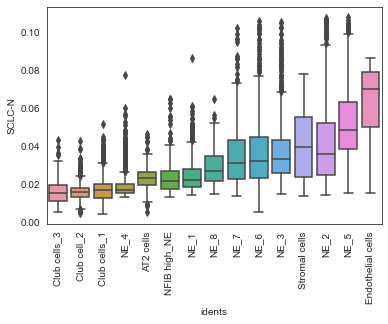

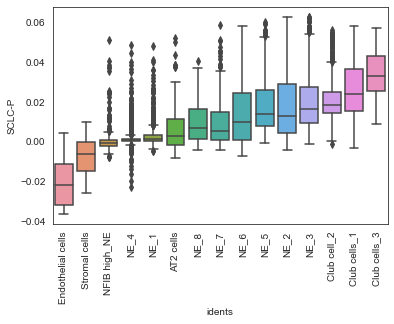

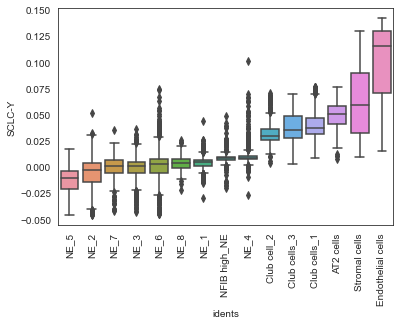

In [45]:
out.index = imputed_data.index
out.columns = sig_matrix.columns
out.head()
out['idents'] = idents
for i in out.columns[0:5]:
    sns.boxplot(data = out, x = 'idents', y= i, order = out.groupby('idents').mean().sort_values(i).index)
    plt.xticks(rotation = 90)
    plt.show()

In [48]:
imputed_data.to_csv('magic_imputed_no_ciliated.csv')

## Identifying phenotype

In [7]:
phenotype = []

df = adata.obs[[f"{x}_Score_pos" for x in ['SCLC-N', 'SCLC-A', 'SCLC-P', 'SCLC-Y', 'SCLC-A2']]]

for i, r in df.iterrows():
    test = r * (r > 0)
    if test.max() < .1:
        phenotype.append('Unclassified')

    elif test.max() > .5:
        #     if (test/test.sum()).max()>.9:
        phenotype.append(r.idxmax().split('_')[0])
    else:
        phenotype.append(r.sort_values(ascending=False)[0:2].sort_index().index[0].split('_')[0]+"_"+r.sort_values(ascending=False)[0:2].sort_index().index[1].split('_')[0])


In [8]:
adata.obs['Phenotype_extended'] = phenotype

In [9]:
pd.crosstab( adata.obs['Phenotype'],adata.obs['Phenotype_extended']).style.background_gradient(cmap='viridis')

Phenotype_extended,SCLC-A,SCLC-A2,SCLC-A2_SCLC-A,SCLC-A2_SCLC-N,SCLC-A2_SCLC-P,SCLC-A2_SCLC-Y,SCLC-A_SCLC-N,SCLC-A_SCLC-P,SCLC-A_SCLC-Y,SCLC-N,SCLC-N_SCLC-P,SCLC-N_SCLC-Y,SCLC-P,SCLC-P_SCLC-Y,SCLC-Y,Unclassified
Phenotype,,,,,,,,,,,,,,,,
Generalist,0,0,708,1304,773,1097,881,1577,1125,0,1452,364,0,369,0,0
None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1115
SCLC-A,543,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SCLC-A2,0,513,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SCLC-N,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0
SCLC-P,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0
SCLC-Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80,0


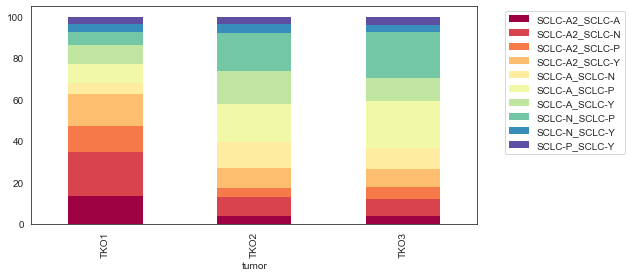

In [10]:
_adata = adata[adata.obs['Phenotype'] == 'Generalist']
plt.rcParams["figure.figsize"] = [8, 4]
((pd.crosstab(_adata.obs["tumor"], _adata.obs['Phenotype_extended']).T /
  pd.crosstab(_adata.obs["tumor"], _adata.obs['Phenotype_extended']).sum(axis=1)) * 100).T.plot(kind='bar',
                                                                                              stacked=True,
                                                                                              linewidth=0, cmap = 'Spectral')
plt.legend(bbox_to_anchor=(1.05, 1))



In [11]:
pd.crosstab( adata.obs['Phenotype_extended'],adata.obs['tumor']).style.background_gradient(cmap='viridis')



tumor,TKO1,TKO2,TKO3
Phenotype_extended,,,
SCLC-A,70,269,204
SCLC-A2,422,50,41
SCLC-A2_SCLC-A,482,112,114
SCLC-A2_SCLC-N,783,272,249
SCLC-A2_SCLC-P,458,128,187
SCLC-A2_SCLC-Y,563,280,254
SCLC-A_SCLC-N,238,477,433
SCLC-A_SCLC-P,340,539,698
SCLC-A_SCLC-Y,326,459,340


## Newer phenotype classification with labeled generalists
Let's check to see how many samples have significant scores (p>.3) for more than one phenotype.

<BarContainer object of 3 artists>

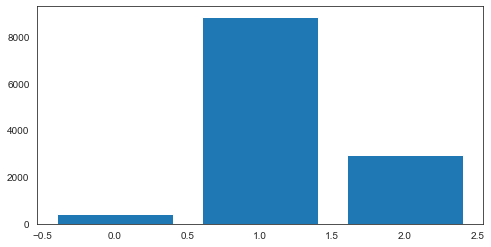

In [12]:
df = adata.obs[[f"{x}_Score_pos" for x in ['SCLC-N', 'SCLC-A', 'SCLC-P', 'SCLC-Y', 'SCLC-A2']]]
# np.unique((df > .3).sum(axis = 1), return_counts=True)[1]
plt.bar(height = np.unique(((df.T/df.sum(axis = 1)).T > .33).sum(axis = 1), return_counts=True)[1], x = range(3), log=False)

In [13]:
arc_pheno = []
arc_aa_type = []

for i,r in df.iterrows():
    r = r/r.sum()
    if (r > .33).sum() > 1:
        arc_aa_type.append('Generalist')
        arc_pheno.append(r.sort_values(ascending=False)[0:2].sort_index().index[0].split('_')[0]+"_"+r.sort_values(ascending=False)[0:2].sort_index().index[1].split('_')[0])
    elif  (r > .33).sum() == 1:
        try:
            arc_aa_type.append(r.idxmax().split('_')[0]+" Specialist")
            arc_pheno.append(r.idxmax().split('_')[0])
        except AttributeError: 
            arc_aa_type.append("Unclassified")
            arc_pheno.append("Unclassified")
    else: 
        arc_aa_type.append("Unclassified")
        arc_pheno.append("Unclassified")
adata.obs['arc_pheno'] = arc_pheno
adata.obs['arc_aa_type'] = arc_aa_type


In [14]:
pd.crosstab(adata.obs['arc_pheno'],adata.obs['tumor']).style.background_gradient(cmap='viridis')

tumor,TKO1,TKO2,TKO3
arc_pheno,,,
SCLC-A,702,1052,974
SCLC-A2,1788,402,427
SCLC-A2_SCLC-A,192,45,51
SCLC-A2_SCLC-N,170,92,87
SCLC-A2_SCLC-P,169,48,73
SCLC-A2_SCLC-Y,148,82,66
SCLC-A_SCLC-N,25,65,61
SCLC-A_SCLC-P,131,221,292
SCLC-A_SCLC-Y,92,193,136


In [15]:
pd.crosstab( adata.obs['arc_pheno'],adata.obs['Phenotype']).style.background_gradient(cmap='viridis')

Phenotype,Generalist,None,SCLC-A,SCLC-A2,SCLC-N,SCLC-P,SCLC-Y
arc_pheno,,,,,,,
SCLC-A,2093,113,522,0,0,0,0
SCLC-A2,2002,114,0,501,0,0,0
SCLC-A2_SCLC-A,259,29,0,0,0,0,0
SCLC-A2_SCLC-N,309,30,0,10,0,0,0
SCLC-A2_SCLC-P,274,15,0,1,0,0,0
SCLC-A2_SCLC-Y,273,22,0,1,0,0,0
SCLC-A_SCLC-N,118,33,0,0,0,0,0
SCLC-A_SCLC-P,593,49,2,0,0,0,0
SCLC-A_SCLC-Y,361,34,19,0,0,0,7


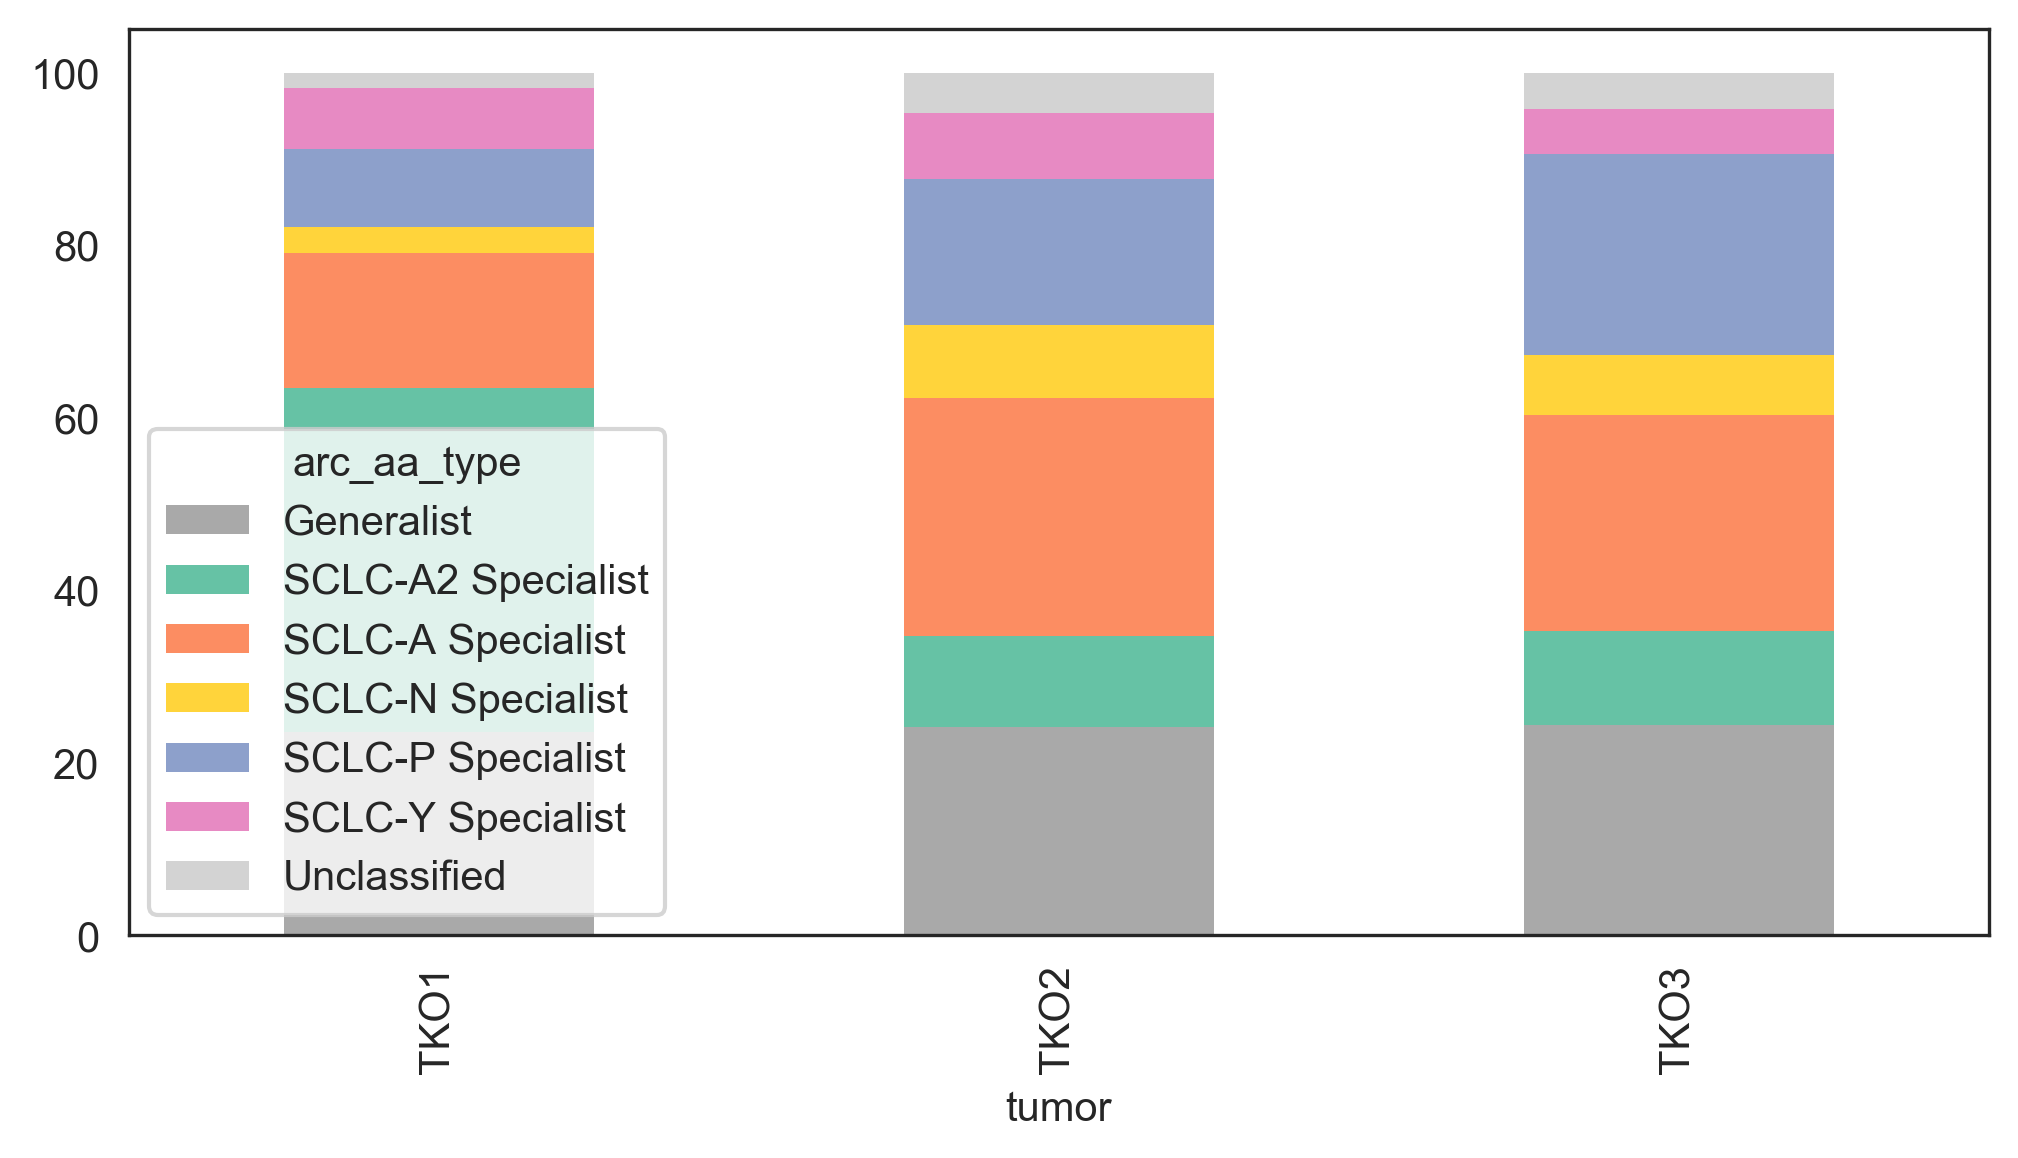

In [7]:
cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
color_dict = {'SCLC-Y Specialist': cp[4], 'SCLC-A Specialist': cp[0], 'SCLC-A2 Specialist': cp[1], 'SCLC-N Specialist': cp[2], 'SCLC-P Specialist': cp[3],
              'Generalist': 'darkgrey', 'Unclassified': 'lightgrey'}
mb.pl.subtype_bar(adata,groupby='tumor', fname = 'tko', pheno_name="arc_aa_type", custom_palette=color_dict)

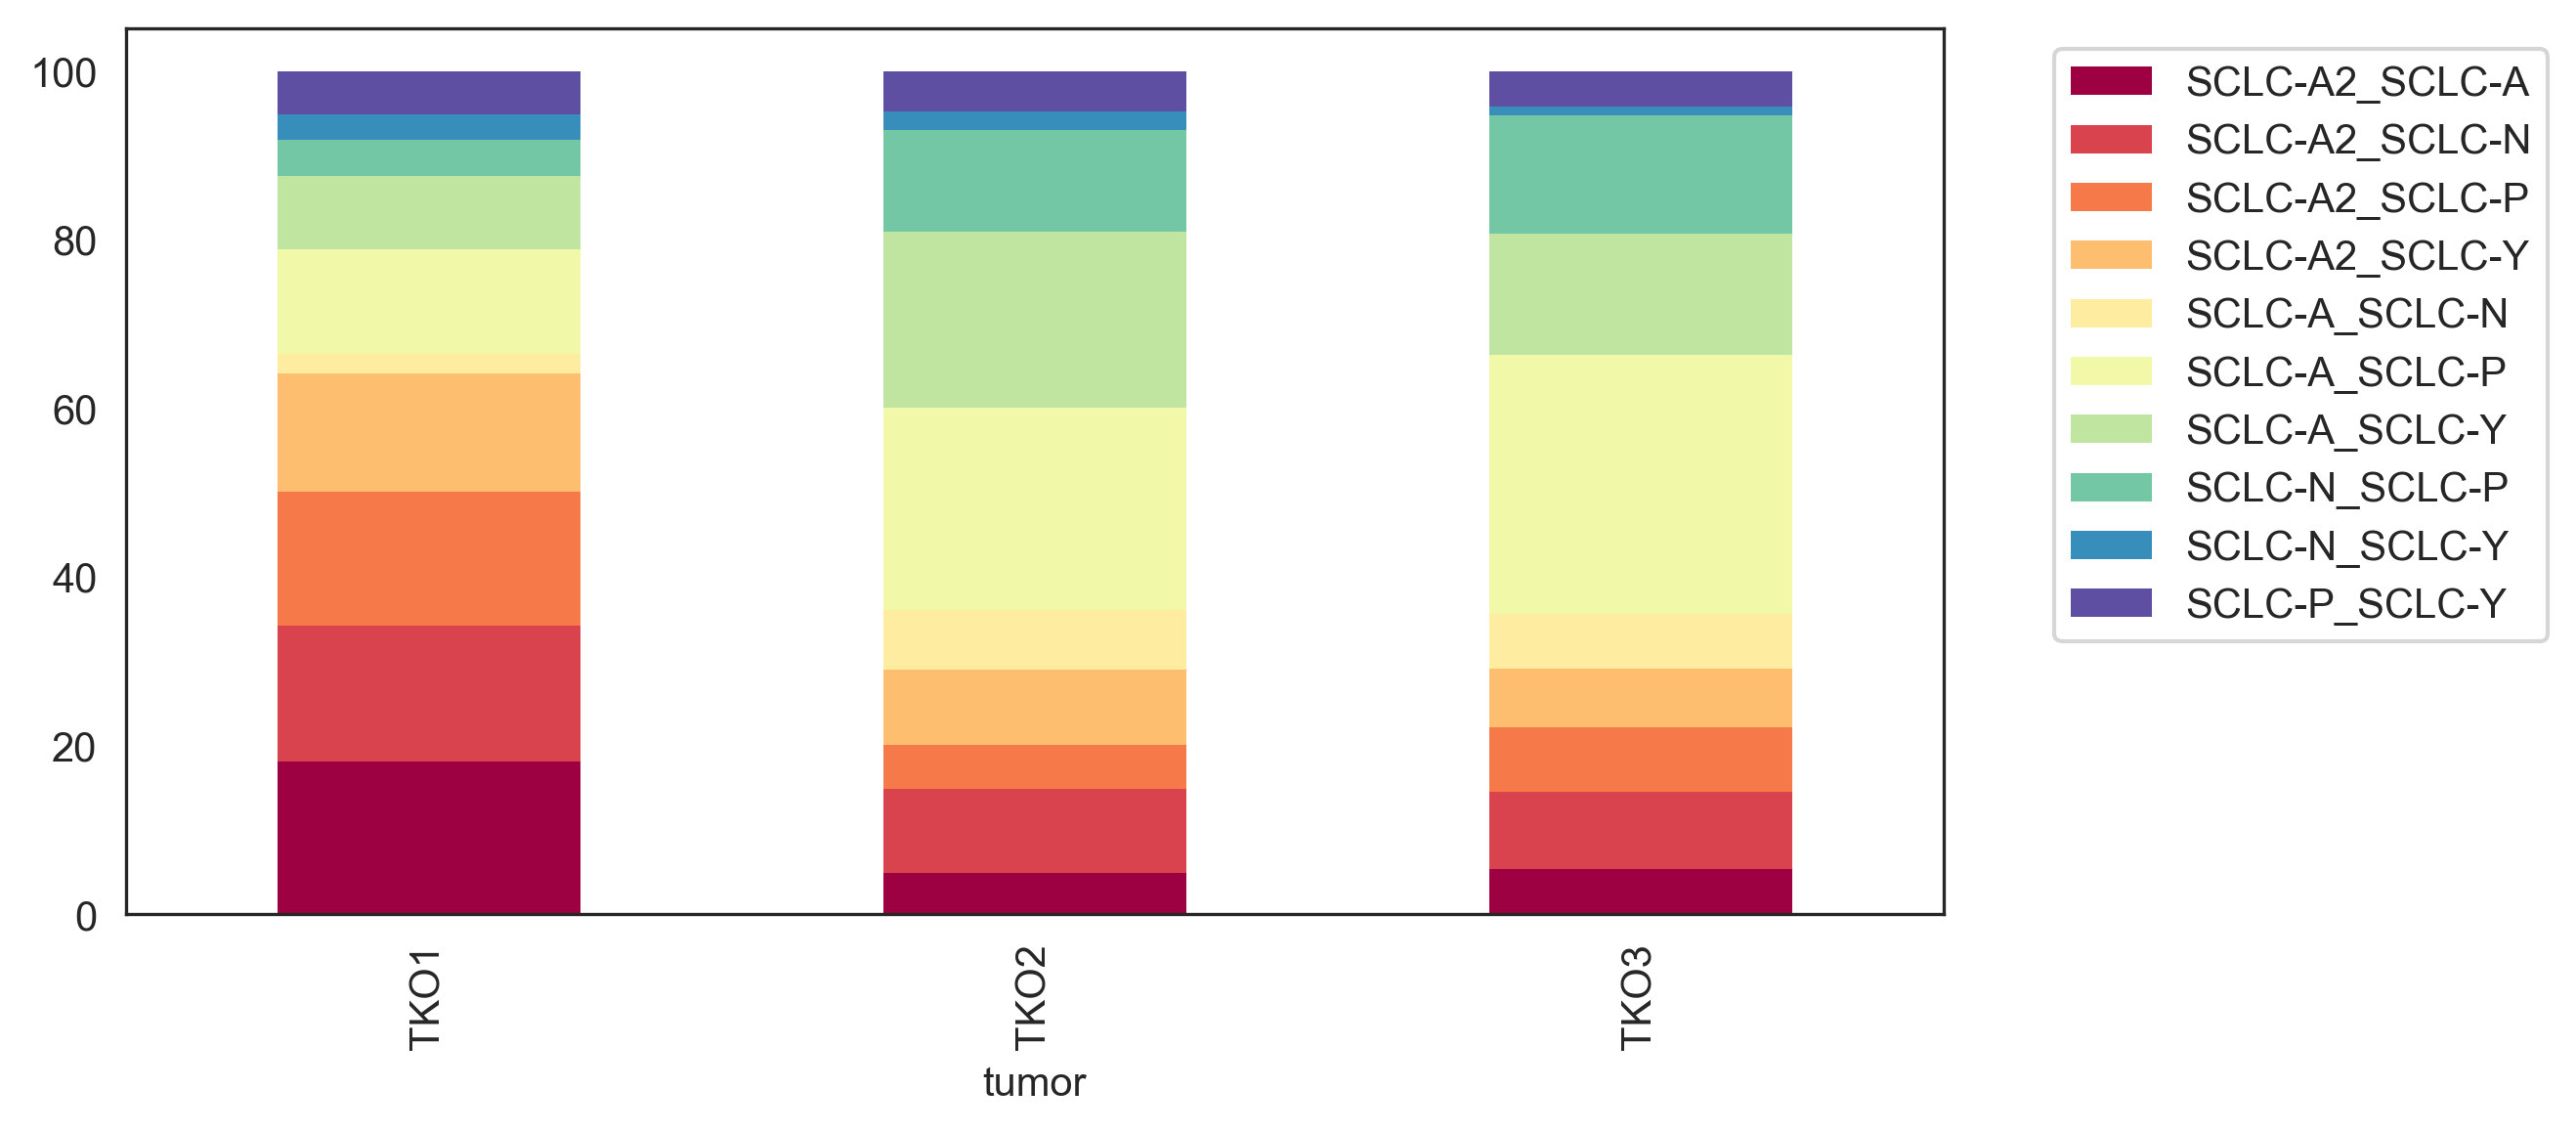

In [19]:
_adata = adata[adata.obs['arc_aa_type'] == 'Generalist']
plt.rcParams["figure.figsize"] = [8, 4]
((pd.crosstab(_adata.obs["tumor"], _adata.obs['arc_pheno']).T /
  pd.crosstab(_adata.obs["tumor"], _adata.obs['arc_pheno']).sum(axis=1)) * 100).T.plot(kind='bar',
                                                                                              stacked=True,
                                                                                              linewidth=0, cmap = 'Spectral')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.savefig('./figures/tko/arc_aa_generalist_subtypes.pdf')

TKO1
Index(['SCLC-A2_Score', 'SCLC-Y_Score', 'SCLC-N_Score'], dtype='object')


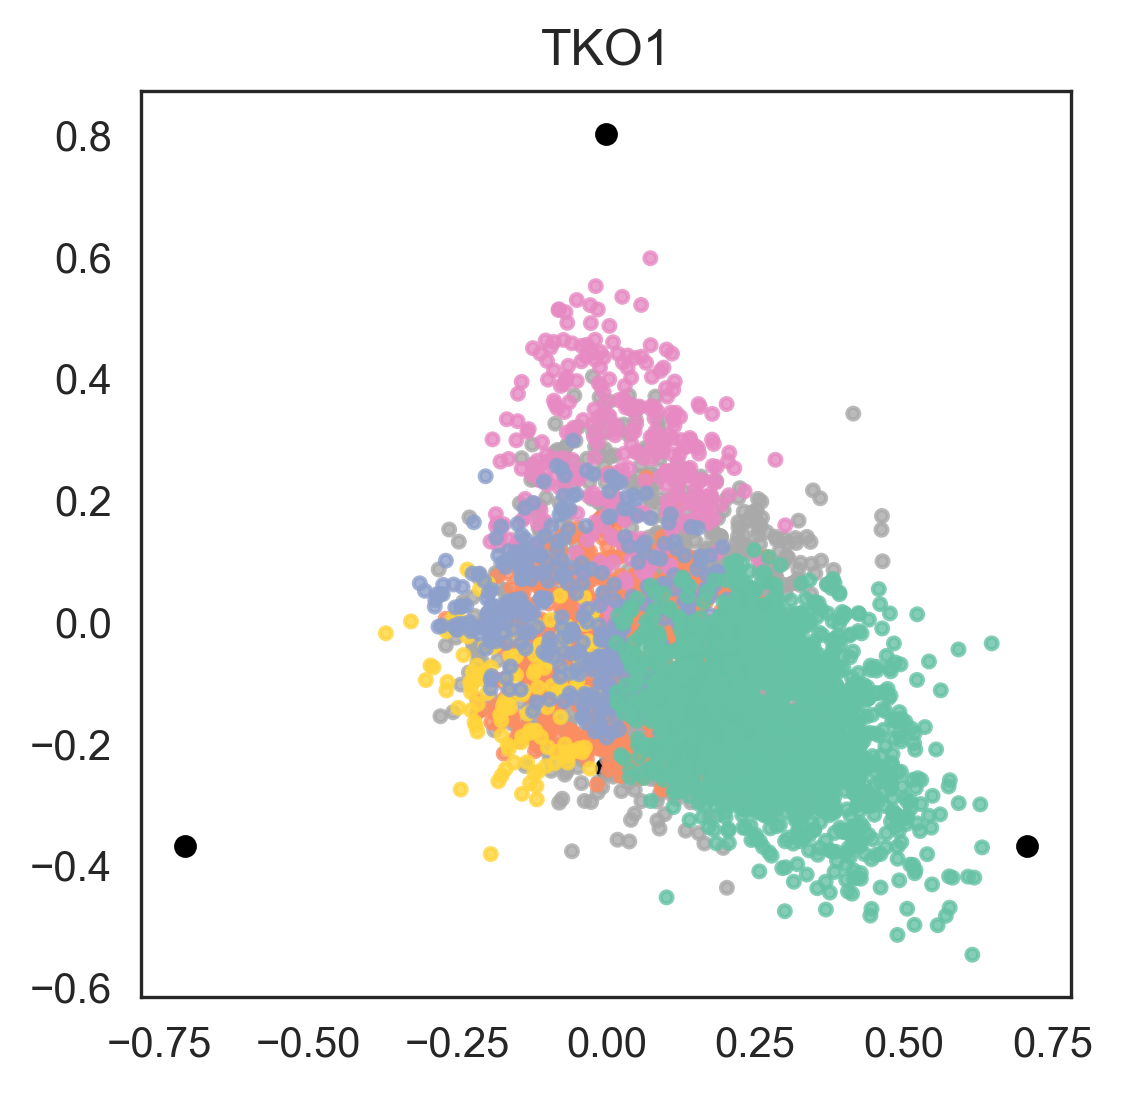

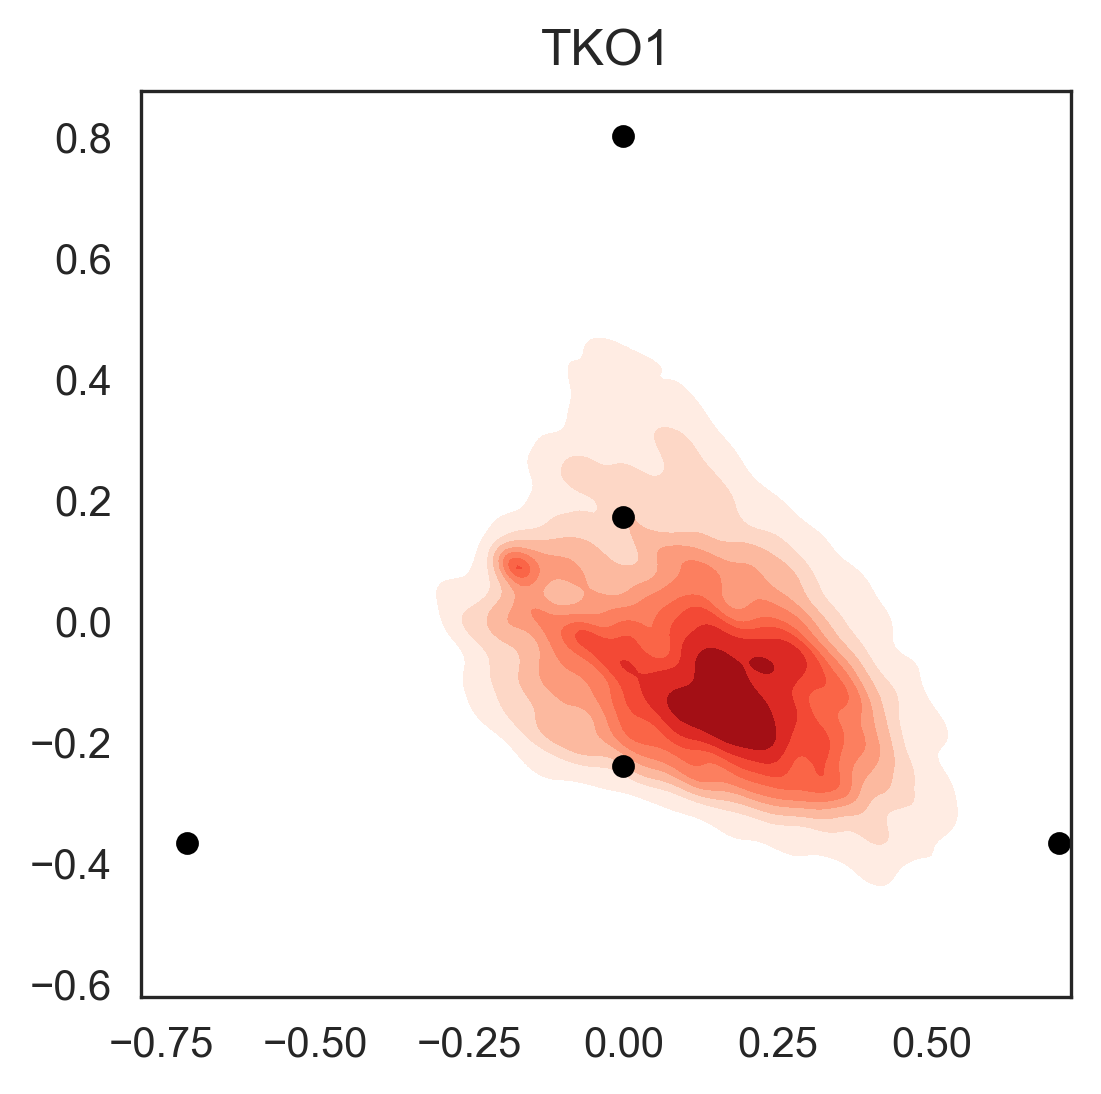

TKO2
Index(['SCLC-A_Score', 'SCLC-P_Score', 'SCLC-Y_Score'], dtype='object')


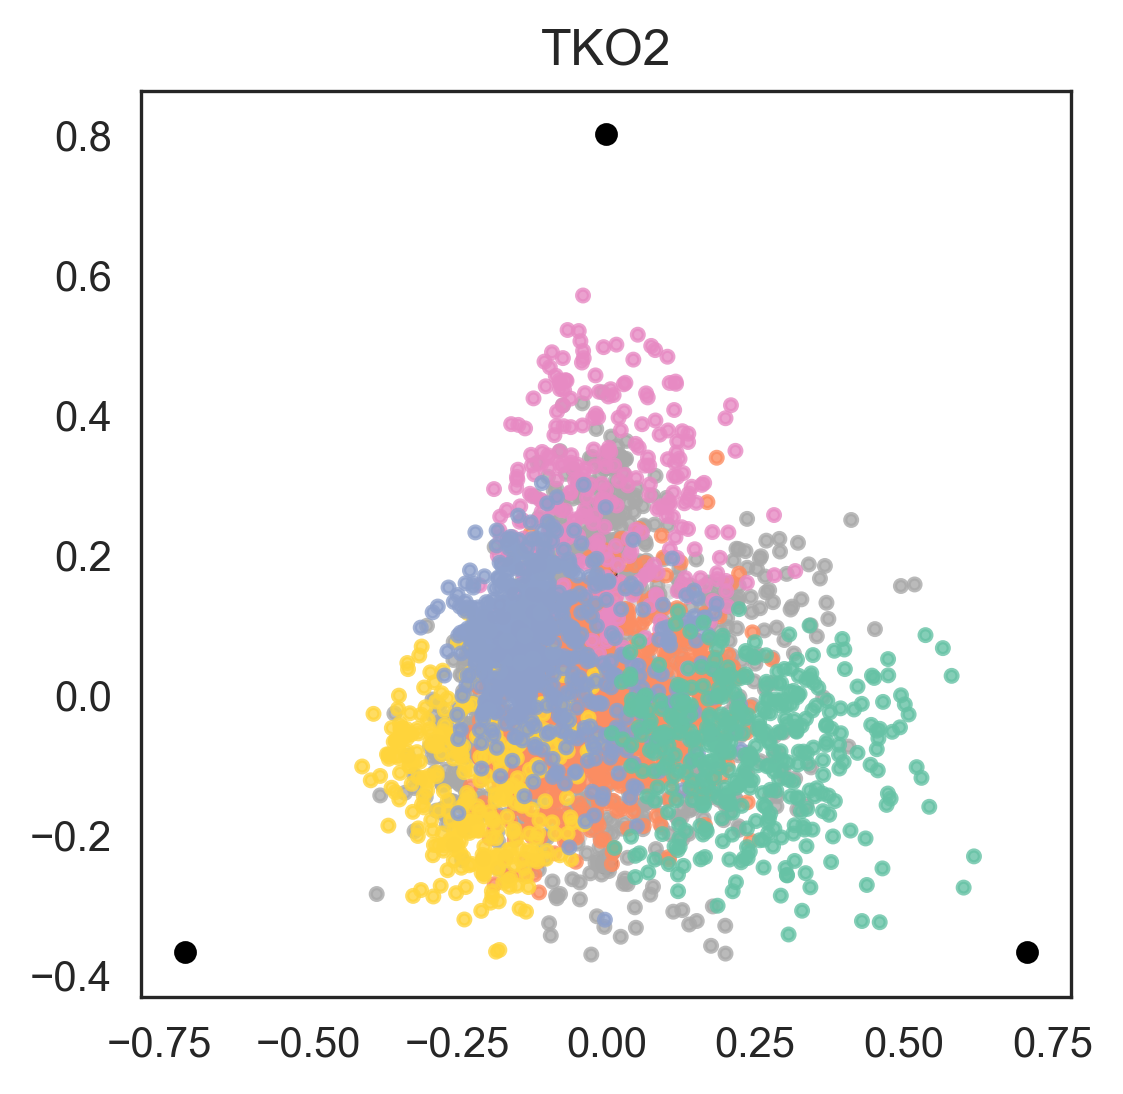

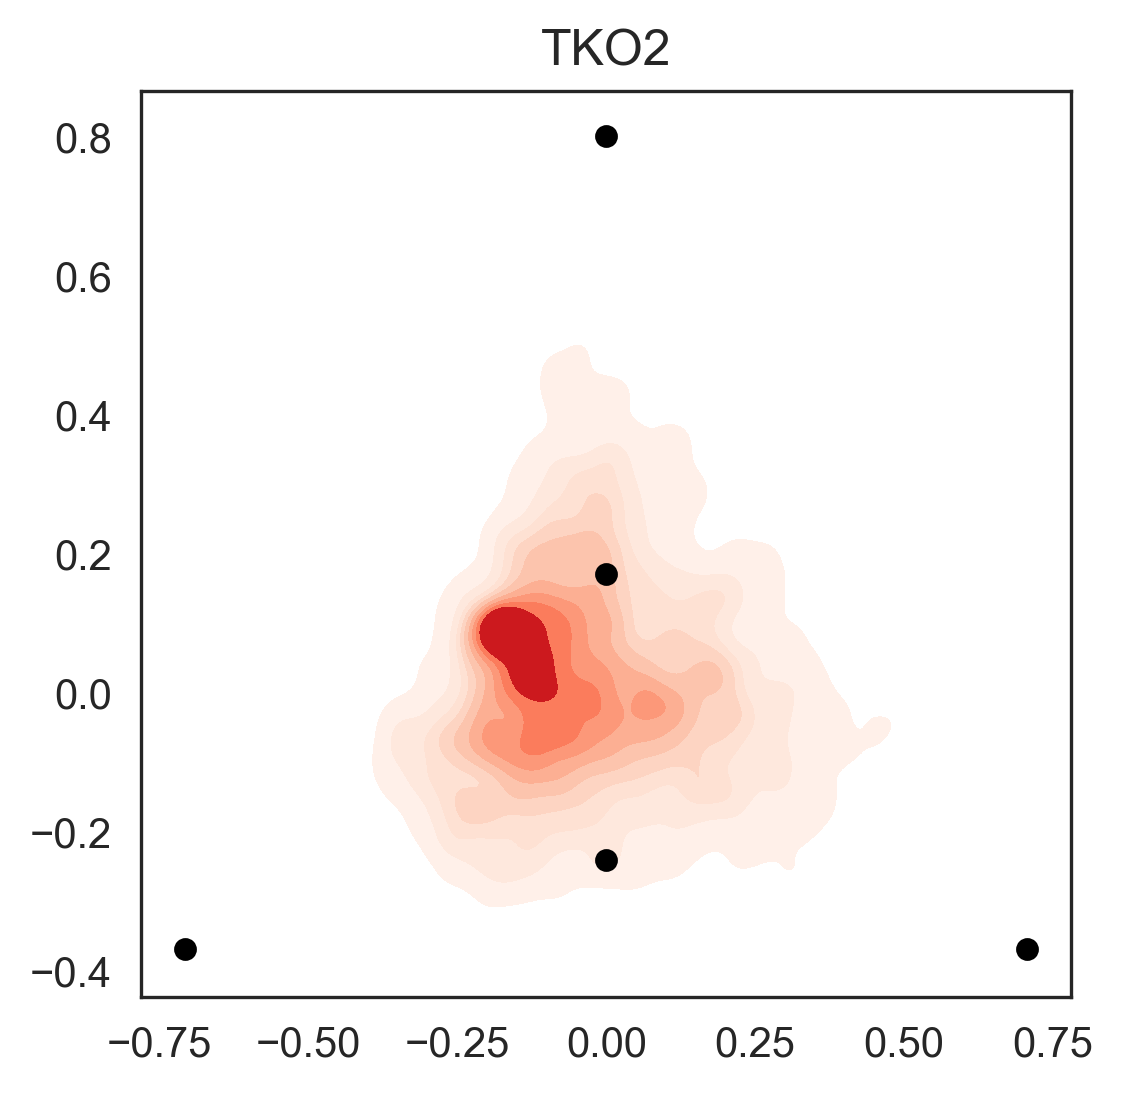

TKO3
Index(['SCLC-P_Score', 'SCLC-A_Score', 'SCLC-Y_Score'], dtype='object')


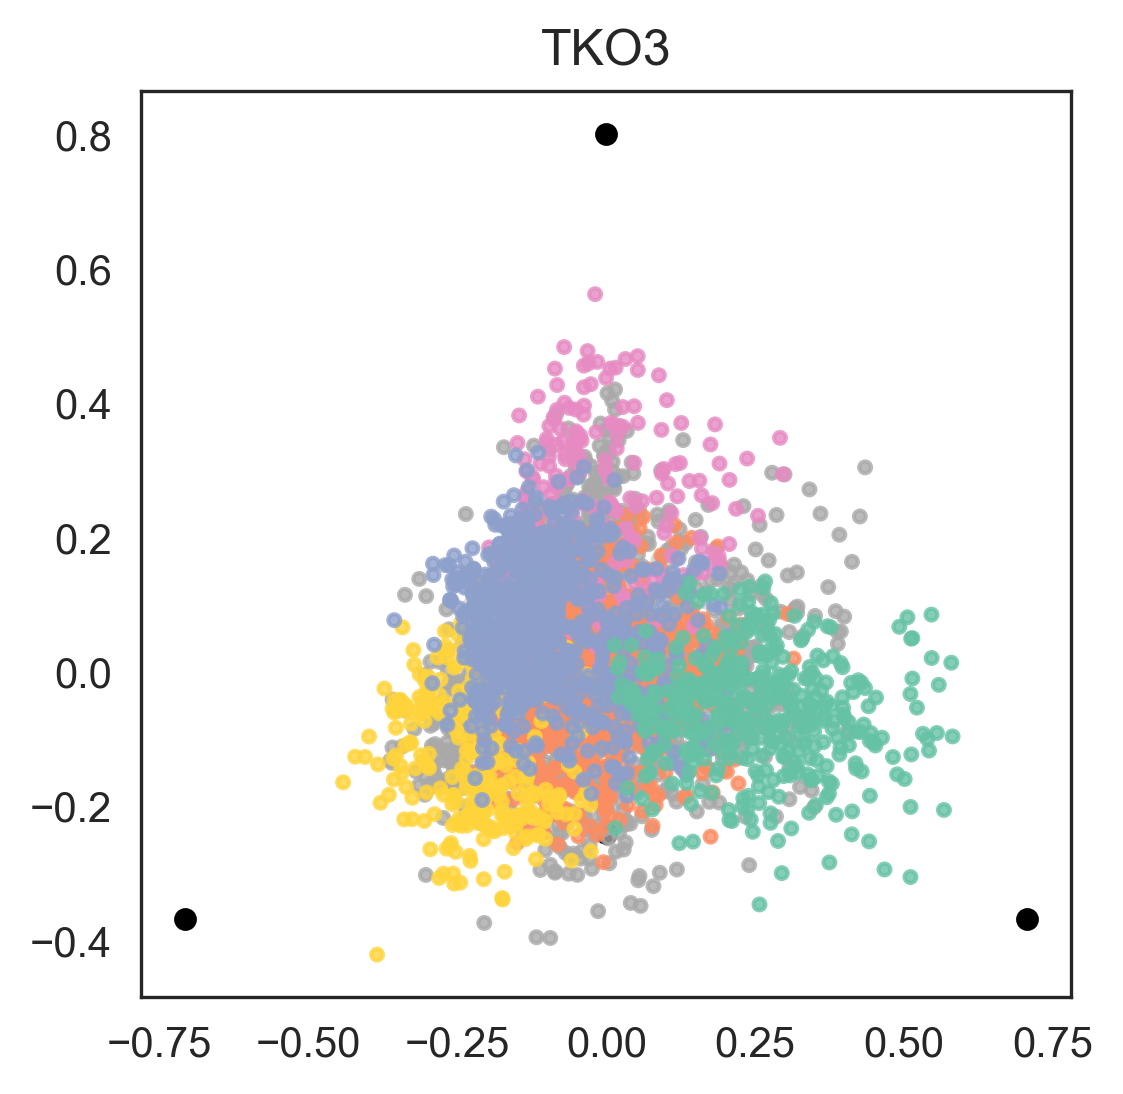

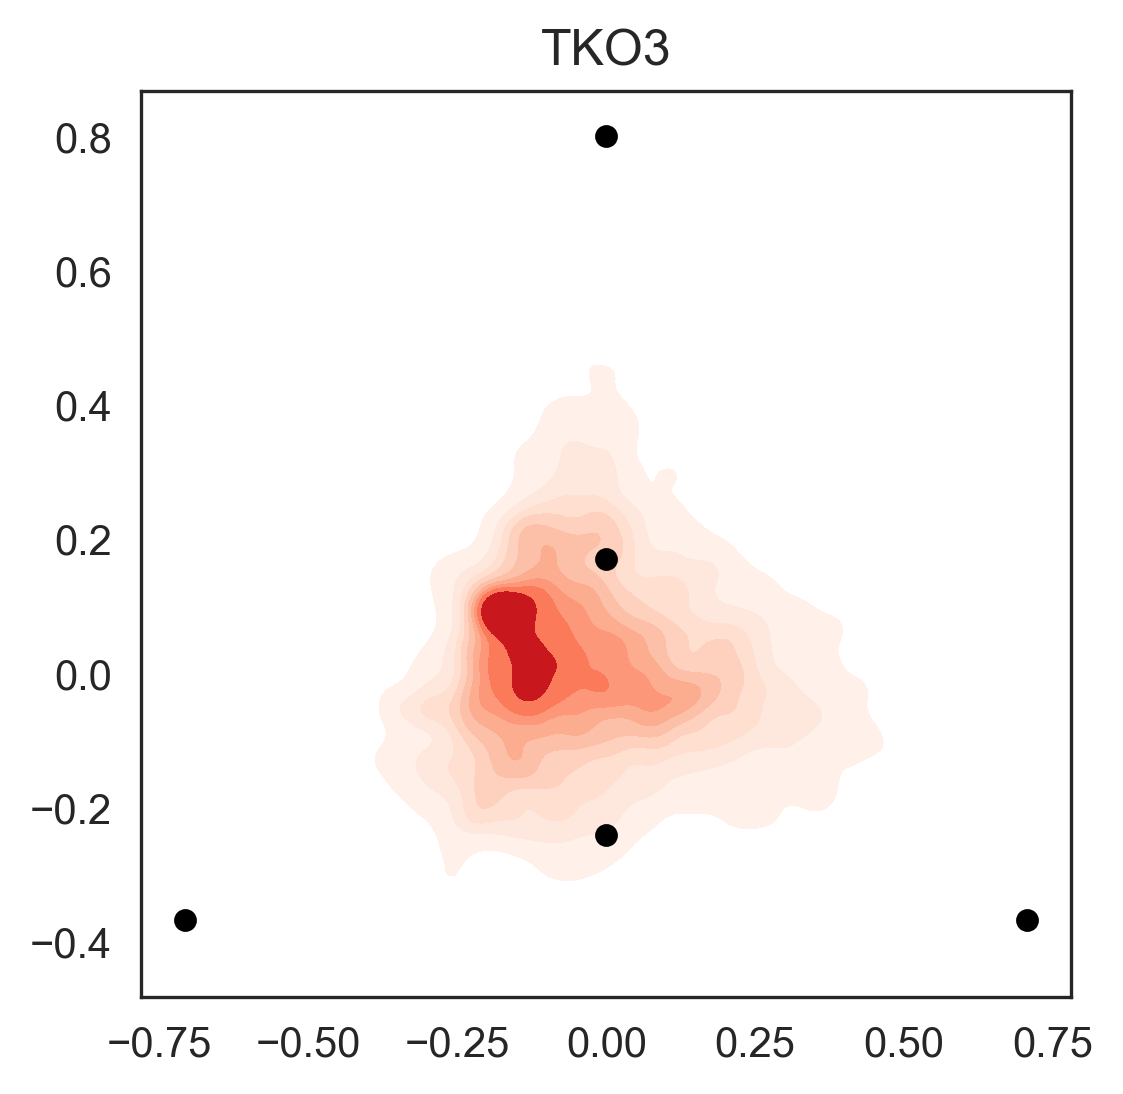

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
color_dict = {'SCLC-Y Specialist': cp[4], 'SCLC-A Specialist': cp[0], 'SCLC-A2 Specialist': cp[1], 'SCLC-N Specialist': cp[2], 'SCLC-P Specialist': cp[3],
              'Generalist': 'darkgrey', 'Unclassified': 'lightgrey'}
mb.pl.archetype_diagrams(adata, sig_matrix, color_dict=color_dict, groupby='tumor',color = 'arc_aa_type',
                        order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',sizes = 20,
                        figsize=(4,4), score_name = '_Score', alpha = .8, s = 8, arrows = False, density = True)


In [22]:
adata.write_h5ad('../int/tko/adata05.h5ad')

... storing 'Phenotype' as categorical
... storing 'Phenotype_extended' as categorical
... storing 'arc_pheno' as categorical
... storing 'arc_aa_type' as categorical
